In [1]:
import pickle
import numpy as np
import scvelo as scv
import torch

from veloproj import *

scv.settings.verbosity = 1

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-5', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'dentategyrus_model.cpt',
                               '--exp-name', 'CohAE_dentategyrus',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "X",
                               '--ld_nb_g_src', "X",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'clusters',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:2', exp_name='CohAE_dentategyrus', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, is_half=False, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-05, lr_decay=0.9, mask_cluster_list=None, model_name='dentategyrus_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='X', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='clusters', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("OPC", "OL")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scv.datasets.dentategyrus()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.9 0.1]
AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


  0%|          | 0/2930 [00:00<?, ?cells/s]

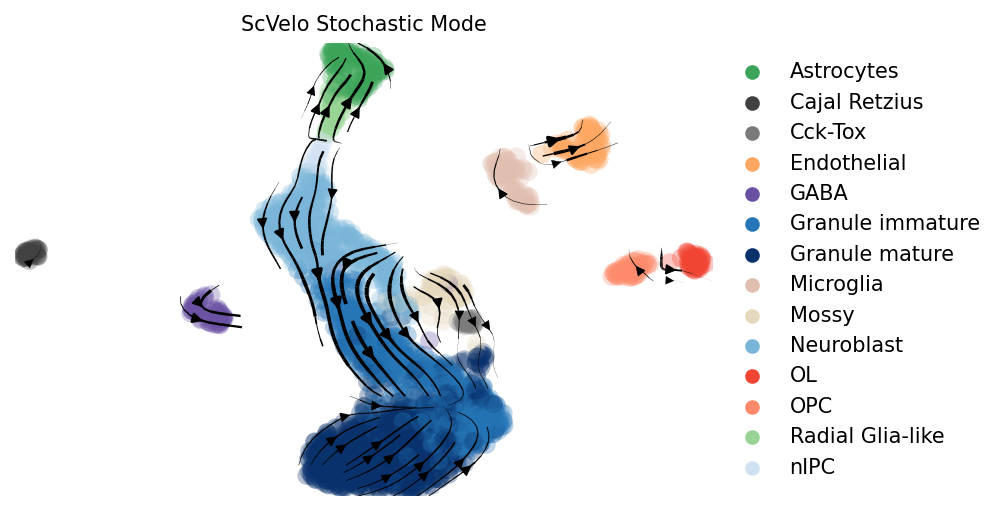

# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.50856084}
Total Mean: 0.508560836315155
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8860751888664318}
Total Mean: -0.8860751888664318
# In-cluster Coherence
{'Astrocytes': 0.8558381, 'Cajal Retzius': 0.98764384, 'Cck-Tox': 0.9481805, 'Endothelial': 0.9474052, 'GABA': 0.90869683, 'Granule immature': 0.84499514, 'Granule mature': 0.80969393, 'Microglia': 0.9754824, 'Mossy': 0.89986503, 'Neuroblast': 0.93088305, 'OL': 0.95064867, 'OPC': 0.9220432, 'Radial Glia-like': 0.8904977, 'nIPC': 0.9444319}
Total Mean: 0.9154504537582397
# In-cluster Confidence
{'Astrocytes': 0.891695033510526, 'Cajal Retzius': 0.9845357782700482, 'Cck-Tox': 0.8860627832236113, 'Endothelial': 0.8625863043741248, 'GABA': 0.8818322234466428, 'Granule immature': 0.8406853706973374, 'Granule mature': 0.8008350233608317, 'Microglia': 0.876839280128479, 'Mossy': 0.

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="stc_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=150, 
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")

Loss: (Total) 0.417646, (AE) 0.415409, (LR) 1.00 * 0.002237: 100%|██████████| 20000/20000 [18:20<00:00, 18.17it/s]


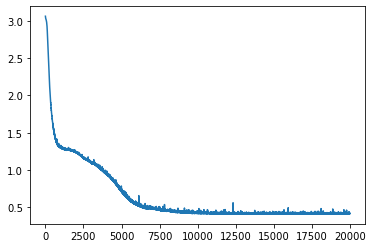

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/2930 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_dentategyrus_pojection.png


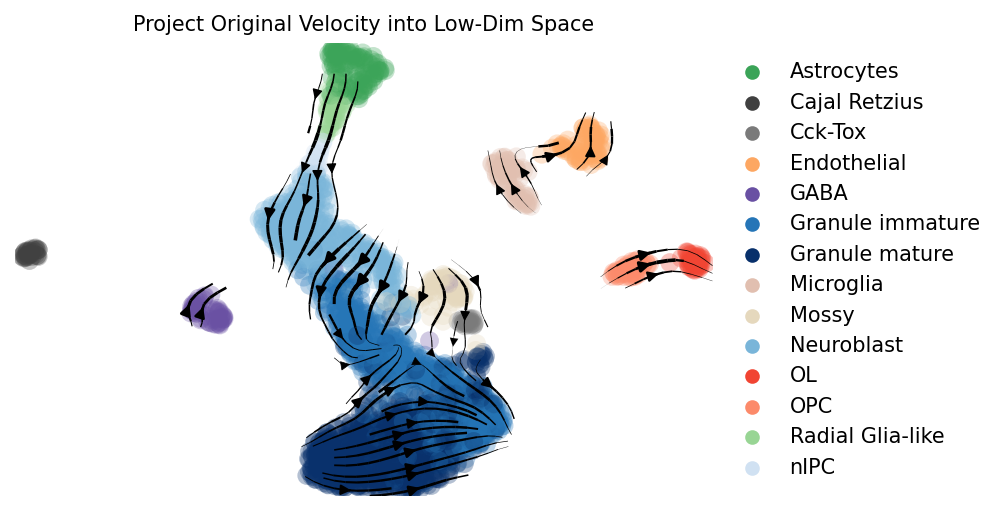

# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.90051174}
Total Mean: 0.9005117416381836
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.9944857}
Total Mean: 0.9944856762886047
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.9527885152243714}
Total Mean: 0.9527885152243714
# In-cluster Coherence
{'Astrocytes': 0.99977034, 'Cajal Retzius': 0.99999607, 'Cck-Tox': 0.9999602, 'Endothelial': 0.9978869, 'GABA': 0.9998192, 'Granule immature': 0.999829, 'Granule mature': 0.9997522, 'Microglia': 0.9971513, 'Mossy': 0.99973214, 'Neuroblast': 0.9996376, 'OL': 0.9990387, 'OPC': 0.99986994, 'Radial Glia-like': 0.9995015, 'nIPC': 0.9996129}
Total Mean: 0.9993969798088074
# In-cluster Confidence
{'Astrocytes': 0.9997433443864187, 'Cajal Retzius': 0.9999696244211758, 'Cck-Tox': 0.9993802684324758, 'Endothelial': 0.997331025956691, 'GABA': 0.9995094664761277, 'Granule immature': 0.9998264437268494, 'Granule mature': 0.9997415974318424, 'Microglia': 0.997000417591

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        
        spliced = adata.layers['Ms']
        unspliced = adata.layers['Mu']
        tensor_s = torch.FloatTensor(spliced).to(device)
        tensor_u = torch.FloatTensor(unspliced).to(device)
        tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)

        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=150,
                                    save='dentategyrus_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.9 0.1]


  0%|          | 0/955 [00:00<?, ?gene/s]

  0%|          | 0/2930 [00:00<?, ?cells/s]

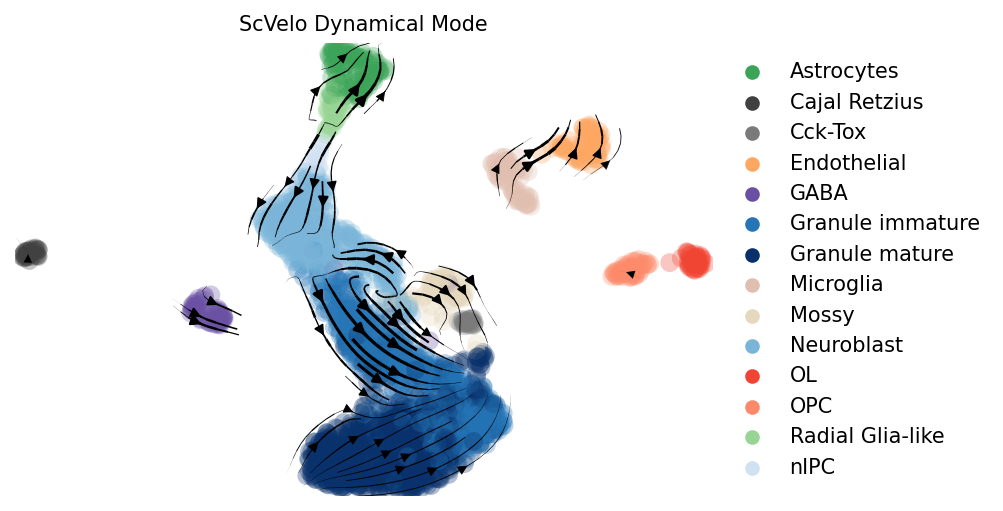

# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.00630295}
Total Mean: 0.006302949972450733
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.3934500415874338}
Total Mean: 0.3934500415874338
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.4227274062633888}
Total Mean: -0.4227274062633888
# In-cluster Coherence
{'Astrocytes': 0.7609318681810356, 'Cajal Retzius': 0.9378692715572066, 'Cck-Tox': 0.828734583852736, 'Endothelial': 0.9314706331659218, 'GABA': 0.882795543614253, 'Granule immature': 0.7868408703982197, 'Granule mature': 0.7489468911509204, 'Microglia': 0.7524512450389534, 'Mossy': 0.8492471138928402, 'Neuroblast': 0.7524816364622642, 'OL': 0.9347272229079507, 'OPC': 0.9451652802702815, 'Radial Glia-like': 0.9283747568913194, 'nIPC': 0.9197938162835281}
Total Mean: 0.8542736238333878
# In-cluster Confidence
{'Astrocytes': 0.7537898279256907, 'Cajal Retzius': 0.9332962276885705, 'Cck-Tox': 0.7505103008792292, 'Endothelial': 0.9221172614286053

In [10]:
adata = scv.datasets.dentategyrus()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=150, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [11]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)